##  MLP Classifier

1. Add one extra hidden layer 
2. Change the ReLU activations to sigmoid activations at all hidden layers
3. Not change anything else (i.e., keep the softmax activation, etc.)
4. Change the textual description of the neural network, its foward and backward passes

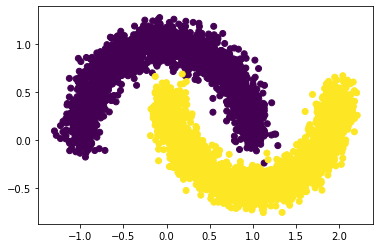

In [1]:
%matplotlib inline
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import pylab
import numpy as np

X, y = make_moons(n_samples=5000, random_state=42, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.3)

pylab.scatter(X[:,0], X[:,1], c=y)
pylab.show()

### Create the Neural Network Weights and Initialize Them

We first define:
* the input layer (two coordinates)
* number of hidden layers (we will use **two**)
* the number of output neurons (number of classes, two in our case) 


In [2]:
# There are only two features in the data X[:,0] and X[:,1]
n_feature = 2

# There are only two classes: 0 (purple) and 1 (yellow)
n_class = 2

def init_weights(n_hidden=100):
    # Initialize weights with Standard Normal random variables
    model = dict(
        W1=np.random.randn(n_feature + 1, n_hidden),
        
        # The weights corresponding to the additional hidden layer. 
        W2=np.random.randn(n_hidden + 1, n_hidden),
        
        W3=np.random.randn(n_hidden + 1, n_class)
    )

    return model

### Define the nonlinear activation function (will be used in the last layer)

We will use the softmax function. 

$$
\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

If there are only two classes, the softmax is equivalent to the logistic function (do the math to convince yourself).

#### Python + Numpy tricks
Numpy is *very* handy. If we give a vector $x$, np.exp($x$) returns a vector with all elements of $x$ exponentiated.

If $y$ is a vector, $y$.sum() returns the sum of the elements in $y$.

In [3]:
# Defining the sigmoid (logistic) activation function. 
def sigmoid(x):
    """
        Inputs  : A tensor x.
        Outputs : 1 / (1 + exp(-x)).
    """
    return 1 / (1 + np.exp(-x))

In [4]:
# Defines the softmax function. For two classes, this is equivalent to the logistic regression
def softmax(x):
    return np.exp(x) / np.exp(x).sum()

### Define the forward pass

Here, we define how the neural network get an input $x$ and use the model paramters (weights) $W^{(1)}$, $W^{(2)}$ and $W^{(3)}$, and biases $b^{(1)}$, $b^{(2)}$ and $b^{(3)}$ to predict the class labels of the input.

Forward Pass Equations. : 

**Input Layer to Hidden Layer 1**
$$ z^{(1)} = x W^{(1)} + b^{(1)} $$
$$ h^{(1)} = SIGMOID(z^{(1)}) $$

**Hidden Layer 1 to Hidden Layer 2**
$$ z^{(2)} = h^{(1)} W^{(2)} + b^{(2)} $$
$$ h^{(2)} = SIGMOID(z^{(2)}) $$

**Hidden Layer 2 to Output Layer**
$$ z^{(3)} = h^{(2)} W^{(3)} + b^{(3)} $$
$$ \hat{y}  = SOFTMAX(z^{(3)}) $$

ReLU Activation : 
$$
\text{ReLU}(z) = \begin{cases} z & ,\text{if }z \geq 0 \\
0 & ,\text{if }z < 0
\end{cases}
$$

Sigmoid Activation : 
$$
f(x) = \frac{1}{( 1 + e^{(-x)})}
$$


In [5]:
# For a single example $x$
def forward(x, model):
    
    ######### Layer 1 ##########
    
    x = np.append(x, 1)
    
    # Input times first layer matrix 
    z_1 = x @ model['W1']

    # ReLU activation goes to hidden layer. (Comment out the ReLU activation part).
    # h1 = z_1
    # h1[z_1 < 0] = 0
    
    # Activation for the first hidden layer. 
    h1 = sigmoid(z_1)
    
    
    ######### Layer 2 ##########
    
    # Incorporation of the bias unit in the output of the first layer.
    h1 = np.append(h1, 1)
    
    # Output of the first hidden layer times second layer matrix.
    z_2 = h1 @ model['W2']
    
    # ReLU activation goes to hidden layer. (Comment out the ReLU activation part).
    # h2 = z_2
    # h2[z_2 < 0] = 0
    
    # Activation for the first hidden layer. 
    h2 = sigmoid(z_2)
    
    ######### Layer 3 ##########
    
    # Incorporation of the bias unit in the output of the second layer. 
    h2 = np.append(h2, 1)
    
    # Output of the second hidden layer times third layer matrix.
    z_3 = h2 @ model['W3']
    
    hat_y = softmax(z_3)

    return h1, h2, hat_y

### Define backpropagation

Now, we need to backpropagate the derivatives of each example

The backpropagation function gets:
* all input data $\{x_i\}_i$
* corresponding hidden values of *all* training examples: $\{h_i\}_i$ (for all the hidden layers part of our network)
* errors of each output neuron for *all* training examples: $\{y_i - \hat{y}_i\}_i$ (this is a subtraction of two vectors)

Our score function of training example $i$ will be, which is the log likelihood of a one-hot enconding vector of the classes,
$$
L(i) = \sum_j y_i(j) \log \hat{y}_i(j) ,
$$
where $y_i(j)$ is the element $j$ of the vector representing the one-hot enconding of the class of training example $i$ and $\hat{y}_i(j)$ is the output of the $j$-th output neuron for training example $i$,
$$
\hat{y}_i(j) = \frac{\exp(z^{(2)}(j))}{\sum_k \exp(z^{(2)}(k))}.
$$

The derivative of the loss with respect to $z_3$ will be a vector (that we will represent using the variables without the index $j$)
$$
\frac{\partial L(i)}{\partial z^{(3)}} = (y_i(1) - \hat{y}_i(1),\ldots,y_i(\text{n_class}) - \hat{y}_i(\text{n_class})) = y_i - \hat{y}_i.
$$
**Note that we can get this derivative directly from the relative error `errs`.**

#### Other derivatives during the backpropation : 

It will compute the following derivatives for each training example:
* The derivatives of the region between the output layer and the second hidden layer.
$$
\frac{\partial L(i)}{\partial W^{(3)}} = \frac{\partial z^{(3)}(i)}{\partial W^{(3)}}  \frac{\partial L(i)}{\partial z^{(3)}} = h^{(2)^T}  (y_i - \hat{y}_i)
$$

$$
\frac{\partial L(i)}{\partial b^{(3)}} = \frac{\partial z^{(3)}(i)}{\partial b^{(3)}}  \frac{\partial L(i)}{\partial z^{(3)}} =  (y_i - \hat{y}_i),
$$

$$
\frac{\partial z^{(3)}(i)}{\partial b^{(3)}} = 1.
$$

* The derivatives with respect to the hidden values of the hidden layer 2 are
$$
\frac{\partial L(i)}{\partial h^{(2)}} = \frac{\partial z^{(3)}(i)}{\partial h^{(2)}}  \frac{\partial L(i)}{\partial z^{(3)}} =  W^{(3)} (y_i - \hat{y}_i)
$$

* We need to keep track of this, because we will be backpropagating this to the previous layer(s).

We then backpropagate $\partial L(i)/\partial h^{(2)} $ to the previous layer (Hidden Layer 1). This will be needed in the final derivative calculations.

The derivatives of the region between the second hidden layer and the first hidden layer.
$$
\frac{\partial L(i)}{\partial W^{(2)}} = \frac{\partial z^{(2)}(i)}{\partial W^{(2)}} \frac{\partial h^{(2)}(i)}{\partial z^{(2)}} \frac{\partial L(i)}{\partial h^{(2)}} = W^{(3)} (y_i - \hat{y}_i) \frac{\partial h^{(2)}(i)}{\partial z^{(2)}} h^{(1)},
$$ 

$$
\frac{\partial L(i)}{\partial b^{(2)}} = \frac{\partial z^{(2)}(i)}{\partial b^{(2)}} \frac{\partial h^{(2)}(i)}{\partial z^{(2)}} \frac{\partial L(i)}{\partial h^{(2)}} = W^{(3)} (y_i - \hat{y}_i) \frac{\partial h^{(2)}(i)}{\partial z^{(2)}},
$$ 

$$
\frac{\partial z^{(2)}(i)}{\partial W^{(2)}} = h^{(1)},
$$

$$
\frac{\partial z^{(2)}(i)}{\partial b^{(2)}} = 1,
$$

Derivative of the sigmoid function is as follows : 
$$
\frac{\partial f(x)}{\partial x} = f(x) \times (1 - f(x)) 
$$

* The derivatives with respect to the hidden values of the hidden layer 2 are
$$
\frac{\partial L(i)}{\partial h^{(1)}} = \frac{\partial z^{(2)}}{\partial h^{(1)}}  \frac{\partial L(i)}{\partial h^{(2)}} \frac{\partial h^{(2)}}{\partial z^{(2)}}
$$

$$
\frac{\partial z^{(2)}}{\partial h^{(1)}} = W^{(2)}
$$

* We need to keep track of this, because we will be backpropagating this to the previous layer(s).

The derivatives of the region between the input layer and the first hidden layer.

$$
\frac{\partial L(i)}{\partial W^{(1)}} = \frac{\partial z^{(1)}(i)}{\partial W^{(1)}} \frac{\partial h^{(1)}(i)}{\partial z^{(1)}} \frac{\partial L(i)}{\partial h^{(1)}},
$$ 

$$
\frac{\partial z^{(1)}(i)}{\partial W^{(1)}} = x_{i}
$$

$$
\frac{\partial L(i)}{\partial b^{(1)}} = \frac{\partial z^{(1)}(i)}{\partial b^{(1)}} \frac{\partial h^{(1)}(i)}{\partial z^{(1)}} \frac{\partial L(i)}{\partial h^{(1)}},
$$ 

$$
\frac{\partial z^{(1)}(i)}{\partial b^{(1)}} = 1
$$

The final outputs are the derivatives of the parameters.

<span style="color:blue"> In the above, we have described the backpropagation algorithm *per training example*. 
The following python code will, as described earlier, give all examples as inputs. Thus, the input is a matrix whose rows are the vectors of each training example.</span>

This function outputs 
$$
\text{d}W^{(1)} = \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial W^{(1)}},
$$ 
$$
\text{d}b^{(1)} = \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial b^{(1)}},
$$ 
$$
\text{d}W^{(2)} =  \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial W^{(2)}},
$$
$$
\text{d}b^{(2)} =  \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial b^{(2)}},
$$
$$
\text{d}W^{(3)} = \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial W^{(3)}},
$$ 
$$
\text{d}b^{(3)} = \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial b^{(3)}}.
$$

In [6]:
def backward(model, xs, hs1, hs2, errs):
    """
        xs, hs1, hs2 and errs contain all information (input, hidden state 1, hidden state 2, error) of all 
        data in the minibatch.
    """
    
    ######## @@@@@@@@@@@@ Gradient of W3 @@@@@@@@@@@@ ########
    
    # errs is the gradients of output layer for the minibatch
    dW3 = (hs2.T @ errs)/xs.shape[0]

    # Get gradient of hidden layer 2.
    dh2 = errs @ model['W3'].T
    
    # Derivative of the activation function.
    # dh2[hs2 <= 0] = 0 (ReLU Activation derivative).
    
    # (Sigmoid Activation derivative).
    dh2 = dh2 * sigmoid(hs2) * (1 - sigmoid(hs2))
    
    # The bias "neuron" is the constant 1, we don't need to backpropagate its gradient
    # since it has no inputs, so we just remove its column from the gradient
    dh2 = dh2[:, :-1]
    
    ######## @@@@@@@@@@@@ Gradient of W2 @@@@@@@@@@@@ ########

    # Add the 1 to the input (h1), to compute the gradient of W2
    # hs1 = np.hstack([hs1, np.ones((hs1.shape[0], 1))])
    
    # errs is the gradients of first hidden layer for the minibatch
    dW2 = (hs1.T @ dh2)/xs.shape[0]
    
    dh1 = dh2 @ model['W2'].T
    
    # Derivative of the activation function.
    # dh1[hs1 <= 0] = 0 (ReLU Activation derivative).
    
    # (Sigmoid Activation derivative).
    dh1 = dh1 * sigmoid(hs1) * (1 - sigmoid(hs1))
    
    # The bias "neuron" is the constant 1, we don't need to backpropagate its gradient
    # since it has no inputs, so we just remove its column from the gradient
    dh1 = dh1[:, :-1]
    
    ######## @@@@@@@@@@@@ Gradient of W1 @@@@@@@@@@@@ ########
    
    # Add the 1 to the data, to compute the gradient of W1
    xs = np.hstack([xs, np.ones((xs.shape[0], 1))])

    dW1 = (xs.T @ dh1)/xs.shape[0]

    return dict(W1=dW1, W2=dW2, W3=dW3)

### Perform the forward and backward procedures to get gradients

For each input example $i$ in the training data, perform a forward pass and:
* store all the hidden units of all the hidden layers associated with example $i$ (we have to store two vectors of hidden values)
* store the gradient of the error of example $i$ with respect to the prediction.

Once we have store all hidden layer values and all the derivatives of all examples, 
we will do the backard pass and return the derivatives of the error with respect to the paramters $W^{(1)}$, $b^{(1)}$, $W^{(2)}$, $b^{(2)}$, $W^{(3)}$ and $b^{(3)}$.

In [15]:
def get_gradient(model, X_train, y_train):
    xs, hs1, hs2, errs = [], [], [], []

    for x, cls_idx in zip(X_train, y_train):
        h1, h2, y_pred = forward(x, model)

        # Create one-hot coding of true label
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.
            
        # Compute the gradient of output layer
        err = y_true - y_pred

        # Accumulate the informations of the examples
        # x: input
        # h: hidden state
        # err: gradient of output layer
        xs.append(x)
        
        hs1.append(h1)
        # Store the hidden state activations for the hidden layers over the training examples.
        hs2.append(h2)
        
        errs.append(err)

    # Backprop using the informations we get from the current minibatch
    return backward(model, np.array(xs), np.array(hs1), np.array(hs2), np.array(errs))

### Define one gradient ascent step

We now perform a single gradient ascent step.

Get the gradients and perform the following updates for $N$ training examples:
$$
W^{(1)} =W^{(1)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial W^{(1)}},
$$
$$
b^{(1)} =b^{(1)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial b^{(1)}},
$$
$$
W^{(2)} =W^{(2)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial W^{(2)}},
$$
$$
b^{(2)} =b^{(2)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial b^{(2)}},
$$
$$
W^{(3)} =W^{(3)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial W^{(3)}},
$$
$$
b^{(3)} =b^{(3)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial b^{(3)}}.
$$
where $\epsilon = 0.2$ in our example.

In [22]:
def gradient_step(model, X_train, y_train, learning_rate = 0.2):
    grad = get_gradient(model, X_train, y_train)
    
    # A redundant line, that is not really necessary. 
    # model = model.copy()

    # Update every parameters in our networks (W1, W2 and W3) using their gradients
    for layer in grad:
        # Learning rate: 0.2
        print (model[layer].shape)
        print (grad[layer].shape)
        model[layer] += learning_rate * grad[layer]

    return model

### Repeat gradient ascent a few more times...

In [23]:
def gradient_ascent(model, X_train, y_train, no_iter=10):
    for iter in range(no_iter):
        print('Iteration {}'.format(iter))

        model = gradient_step(model, X_train, y_train)

    return model

### Train the model

We now train the model.

In [24]:
no_iter = 200

# Set a random seed (for reproducibility of results). (A good practice).
np.random.seed(47)

# Reset model
model = init_weights()

# Train the model
model = gradient_ascent(model, X_train, y_train, no_iter=no_iter)


Iteration 0
(3, 100)
(3, 100)
(101, 100)
(101, 100)
(101, 2)
(101, 2)
Iteration 1
(3, 100)
(3, 100)
(101, 100)
(101, 100)
(101, 2)
(101, 2)
Iteration 2
(3, 100)
(3, 100)
(101, 100)
(101, 100)
(101, 2)
(101, 2)
Iteration 3
(3, 100)
(3, 100)
(101, 100)
(101, 100)
(101, 2)
(101, 2)
Iteration 4
(3, 100)
(3, 100)
(101, 100)
(101, 100)
(101, 2)
(101, 2)
Iteration 5
(3, 100)
(3, 100)
(101, 100)
(101, 100)
(101, 2)
(101, 2)
Iteration 6
(3, 100)
(3, 100)
(101, 100)
(101, 100)
(101, 2)
(101, 2)
Iteration 7


KeyboardInterrupt: 

#### Let's evaluate the model on test data
Note that the output has two neurons for the two classes. Our prediction will chose the class corresponding to the 
largest output neuron value.

In [ ]:
y_pred = np.zeros_like(y_test)

accuracy = 0

for i, x in enumerate(X_test):
    # Predict the distribution of label
    _, _, prob = forward(x, model)
    # Get label by picking the most probable one
    y = np.argmax(prob)
    y_pred[i] = y

# Accuracy of predictions with the true labels and take the percentage
# Because our dataset is balanced, measuring just the accuracy is OK
accuracy = (y_pred == y_test).sum() / y_test.size
print('Test accuracy after {} gradient steps: {}'.format(no_iter,accuracy))

#### Let's visually evaluate the model on the test data


In [ ]:
pylab.scatter(X_test[:,0], X_test[:,1], c=y_pred)
pylab.show()